# Muffin vs Chihuaha image classification 

## Prequisite For google colab 
**import kaggle file manually in files secrtion in colab**

In [51]:
#! mkdir ~/.kaggle

In [52]:
#! cp kaggle.json ~/.kaggle/

In [53]:
#! chmod 600 ~/.kaggle/kaggle.json

In [54]:
#!kaggle datasets download -d samuelcortinhas/muffin-vs-chihuahua-image-classification

In [55]:
#!unzip /content/muffin-vs-chihuahua-image-classification.zip

## Loading The Dataset 

In [56]:
import torch 
from torch.utils.data import Dataset , DataLoader 
from glob import glob # for searching files path it return a list of files path 
import cv2 #opencv for reading mage files 
import matplotlib.pyplot as plt 
import numpy as np 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import torchvision
from torch import nn #for modelling 
from statistics import mean
from torchvision import models
from torchvision import transforms

In [57]:
## make path for image loading 
train_directory = '/kaggle/input/muffin-vs-chihuahua-image-classification/train/'


### Image loading class 

In [58]:
class muffin_vs_chihuaha(Dataset):
    def __init__(self,folder):
        muffin = glob(train_directory+'muffin/*.jpg') # all muffin file path 
        chihuahua  =glob(train_directory+'chihuahua/*.jpg') # all chihuahua file path 
        self.image_path = chihuahua[:1000] + muffin[:1000] #Concatenate file paths 
        from random import shuffle,seed ;seed(10); shuffle(self.image_path)

        self.target = [1 if path.split('/')[-2].startswith("muffin") else 0 for path in self.image_path ]
    def __len__(self):
        return len(self.target)
    def __getitem__(self, index):
        f = self.image_path[index]
        target = self.target[index]
        image = (cv2.imread(f)[:,:,::-1]) #opencv reads image in BGR format covert it into RGB Format 
        image = cv2.resize(image,(224,224))

        return torch.tensor(image/255).permute(2,0,1).to(device).float(),torch.tensor(target).to(device).float()
        #Normalize every image with divide by 255 
        #torch Datloader percieves image in format of (channels,length,breadth) so permute 
        #finall load the image to device which could be cpu or gpu 


        

In [59]:
data = muffin_vs_chihuaha(train_directory) #object dataset

In [60]:
image,target = data[255]# sample data 

In [61]:
label2class = {"1.0":"muffin","0.0":'chihuahua'}

tensor(1., device='cuda:0')


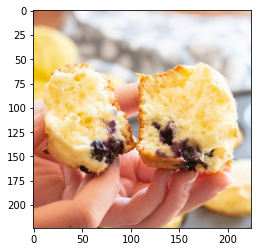

In [62]:
plt.imshow(image.permute(1,2,0).detach().cpu()) #sample image 
print(target)

#### Datloader 
*for giving input to pytorch model we must process input i form of batchs*

In [63]:
trn_dl = DataLoader(data, batch_size=32, shuffle=True, drop_last = True)

In [64]:
image,target = next(iter(trn_dl))
print(image.shape,target.shape)#1 batch consist 0f 32 images 

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [65]:
def imshow(img,title):
    """
    Arguments :
    img - image to plot 

    returns :
    plot of the image with the title 
    """
    img = img.detach().cpu().numpy()
    plt.figure(figsize=(32,10))
    plt.imshow(img.transpose(1,2,0))
    plt.axis('off')
    plt.title(title)
    plt.show()

In [66]:
def plot_batch(dataloader):
    """
    Argument :
    Dataloader - dataloader object of train set 

    return :
    Nothing 

    Work : 
    plot batch of the data 
    """
    image,label = next(iter(dataloader))
    images = torchvision.utils.make_grid(image)
    imshow(images,title= [label2class[str(x.item())] for x in label])


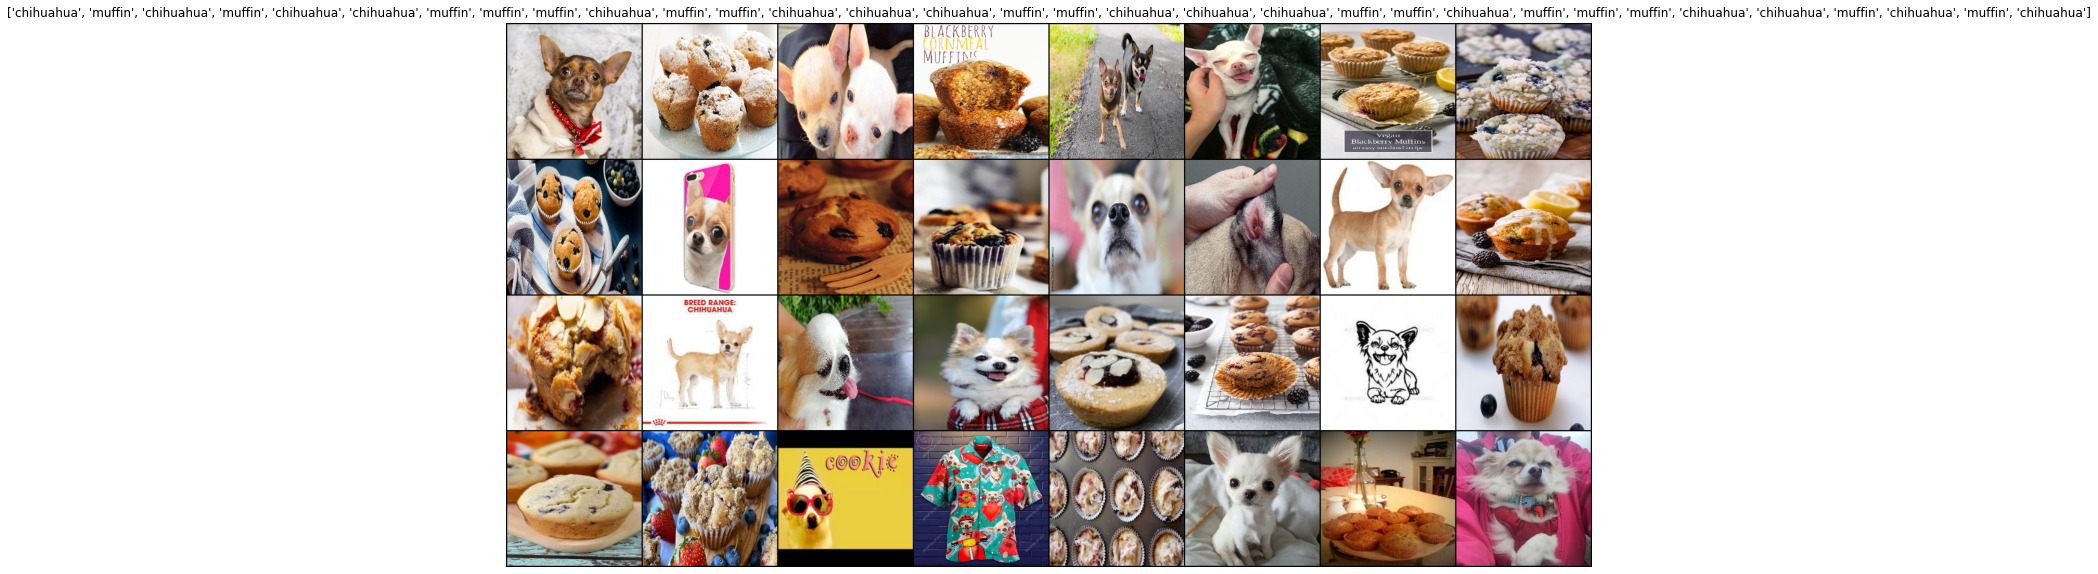

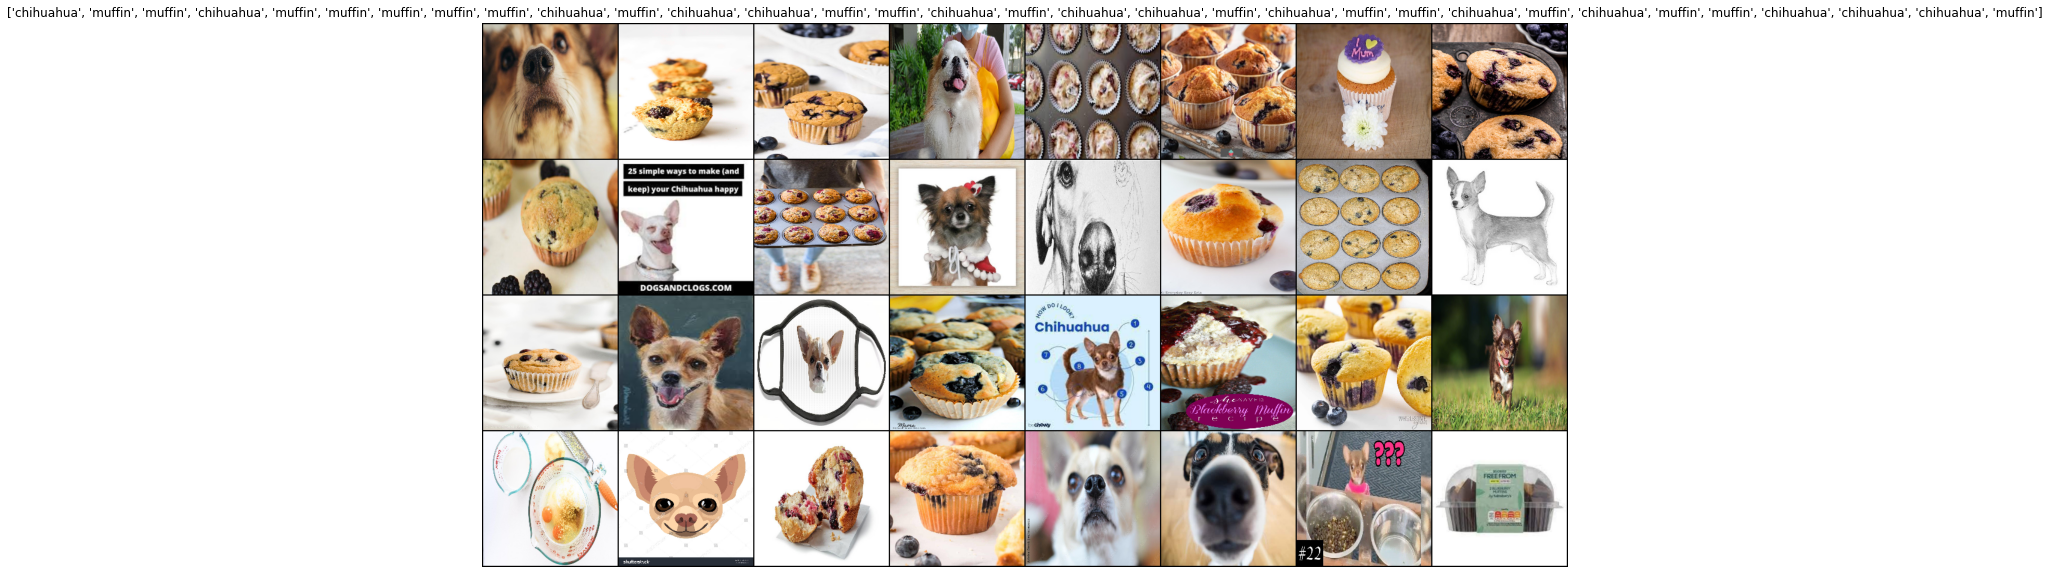

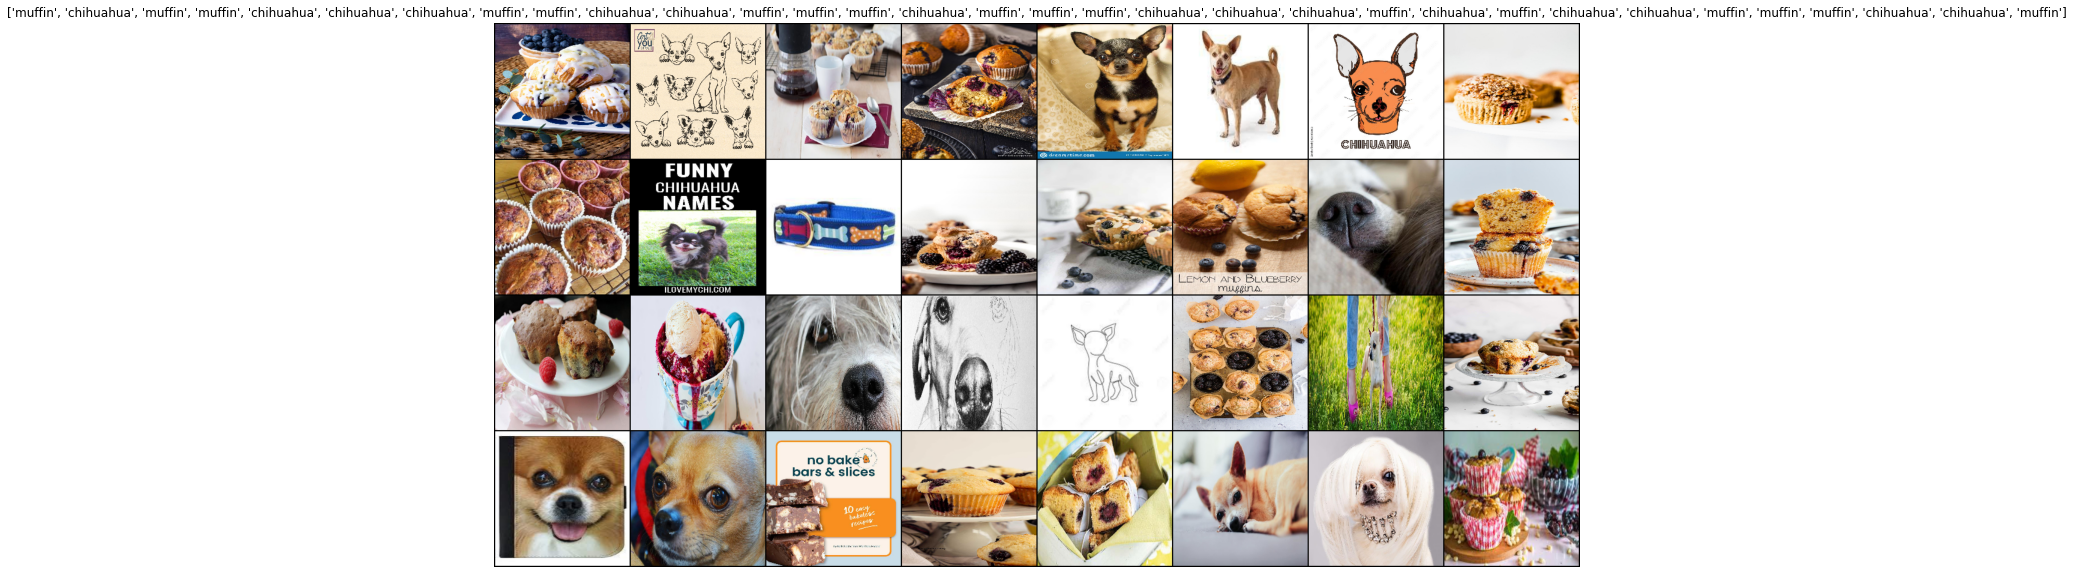

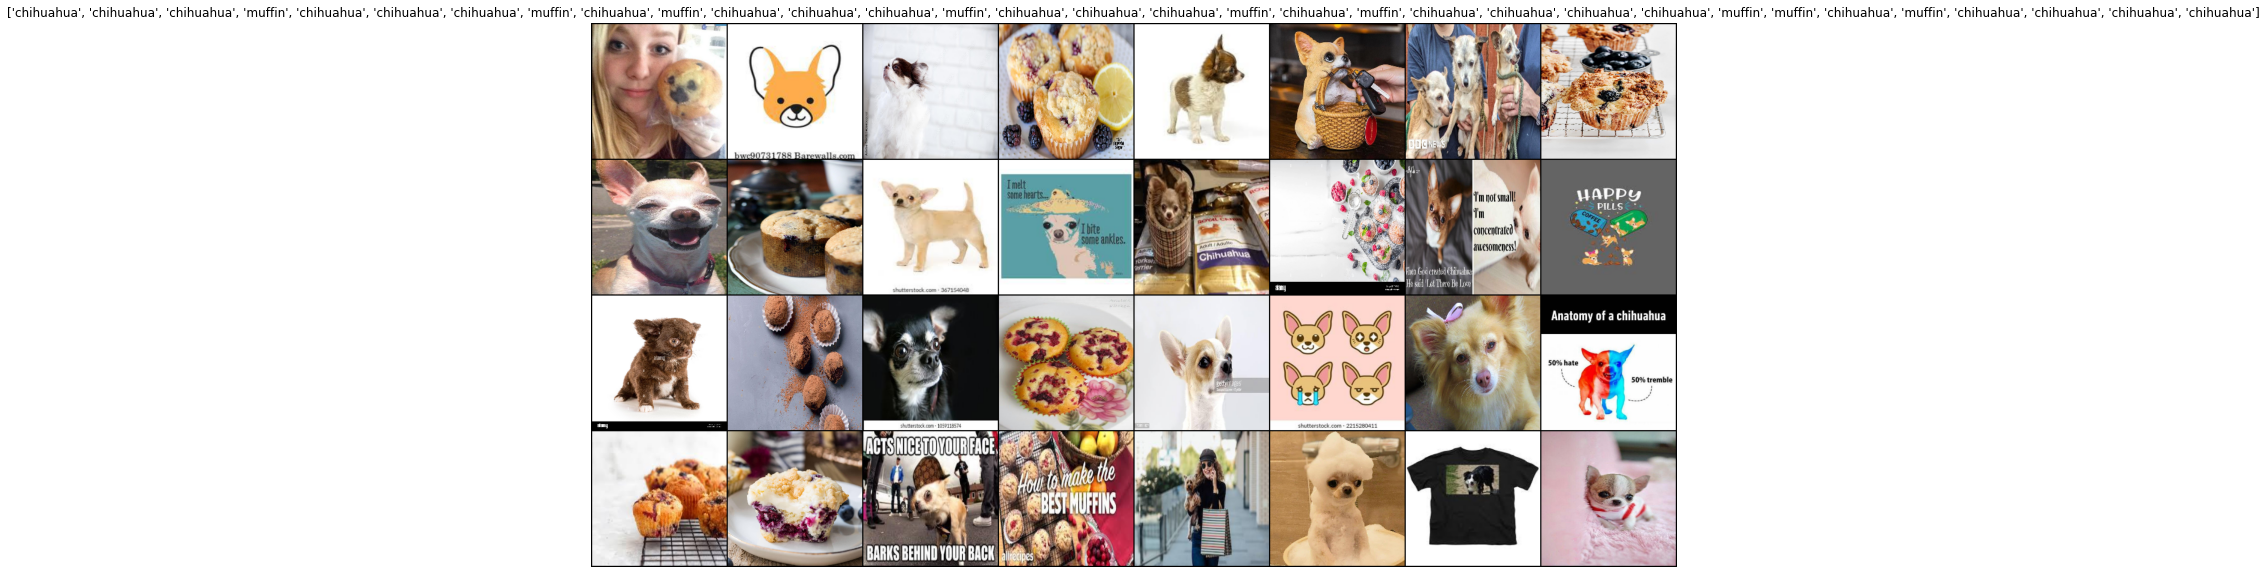

In [67]:
for i in range(4):#plot 4 batch of images 
    plot_batch(trn_dl)

## Modelling

### Model_From_scratch

In [68]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(3,64,3),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2),
        nn.Dropout(.25),
        nn.Conv2d(64,128,3),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2),
        nn.Dropout(.25),
        nn.Conv2d(128,512,3),
        nn.ReLU(),
        nn.BatchNorm2d(512),
        nn.MaxPool2d(2),
        nn.Dropout(0.5),
        nn.Conv2d(512,512,3),
        nn.ReLU(),
        nn.BatchNorm2d(512),
        nn.MaxPool2d(2),
        nn.Dropout(0.5),
        nn.Flatten(),
        nn.Linear(73728,512),
        nn.Linear(512,1),
        nn.Sigmoid(),
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr =1e-3 )
    return model ,loss_fn ,optimizer

In [69]:
def training_batch(model,loss_fn,opt,input,target):
    model.train()
    output = model(input)
    target = target.unsqueeze(1)
    loss= loss_fn(output,target)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [70]:
@torch.no_grad()
def Accuracy(model,input,target):
    """ Arguments :-
    model - model for the data 
    input of the data , 
    target of the data 


    returns - accuracy per batch of the data , it will be a list of True and false respectively 
     """
    model.eval()
    output = model(input)
    prediction = torch.argmax(output,dim= -1)
    accuracy = prediction==target
    return accuracy.detach().cpu().numpy().tolist()

#### Model Summary 

In [71]:
!pip install torch_summary
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(32,3,224,224));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 222, 222]        1,792
├─ReLU: 1-2                              [-1, 64, 222, 222]        --
├─BatchNorm2d: 1-3                       [-1, 64, 222, 222]        128
├─MaxPool2d: 1-4                         [-1, 64, 111, 111]        --
├─Dropout: 1-5                           [-1, 64, 111, 111]        --
├─Conv2d: 1-6                            [-1, 128, 109, 109]       73,856
├─ReLU: 1-7                              [-1, 128, 109, 109]       --
├─BatchNorm2d: 1-8                       [-1, 128, 109, 109]       256
├─MaxPool2d: 1-9                         [-1, 128, 54, 54]         --
├─Dropout: 1-10                          [-1, 128, 54, 54]         --
├─Conv2d: 1-11                           [-1, 512, 52, 52]         590,336
├─ReLU: 1-12                             [-1, 512, 52, 52]         --
├─BatchNorm2d: 1-13                      [-1, 512, 52, 52]         1,02

In [72]:
train_per_epoch_loss = []
accuracy_per_epoch = []
epoch = 5
total = 0 
for i in range(epoch):
    print(f"epoch{i+1}/{epoch+1}")
    loss_per_batch = []

    for ix ,data in enumerate(iter(trn_dl)):
        image,label = data
        loss= training_batch(model, loss_fn, optimizer,image,label)
        loss_per_batch.append(loss)
    loss_per_epoch=mean(loss_per_batch)
    train_per_epoch_loss.append(mean(loss_per_batch))

    total = 0
    mean_accuracy_per_batch= []
    for ix ,data in enumerate(iter(trn_dl)):
        image,label = data 
        accuracy = Accuracy(model,image,label)
        total+=label.shape[0]
        accuracy_per_batch=100*sum(accuracy)/total
        mean_accuracy_per_batch.append(accuracy_per_batch)
    accuracy_measure = mean(mean_accuracy_per_batch)
    accuracy_per_epoch.append(mean(mean_accuracy_per_batch))

    print(f"training loss is {loss_per_epoch}  accuracy is {accuracy_measure}")



epoch1/6
training loss is 49.15487095809752  accuracy is 3.5590631085996307
epoch2/6
training loss is 50.0  accuracy is 3.9377501335634575
epoch3/6
training loss is 50.100806451612904  accuracy is 3.9435361919388057
epoch4/6
training loss is 50.05040322580645  accuracy is 3.7888296116487012
epoch5/6
training loss is 50.100806451612904  accuracy is 3.870262772569481


#### Plotting training and accuracy per epoch 

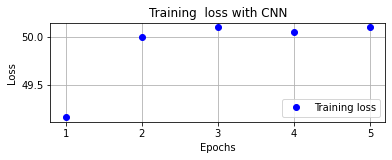

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


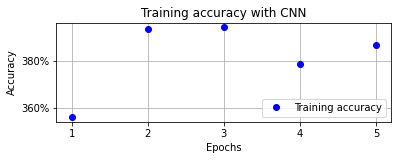

In [73]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_per_epoch_loss, 'bo', label='Training loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training  loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs,accuracy_per_epoch, 'bo', label='Training accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

#### Saving the model 

In [74]:
torch.save(model.state_dict(), '/kaggle/working/model1')

### Pre-trained model 

*we will use transfer learning to get the weights from model which are already trained on some larger generic dataset with more computation i.e more epoch*

In [75]:
model = models.vgg16(pretrained=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [76]:
class muffin_vs_chihuaha(Dataset):
    def __init__(self,folder):
        muffin = glob(train_directory+'muffin/*.jpg') # all muffin file path 
        chihuahua  =glob(train_directory+'chihuahua/*.jpg') # all chihuahua file path 
        self.image_path = chihuahua[:500] + muffin[:500] #Concatenate file paths 
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        from random import shuffle,seed ;seed(10); shuffle(self.image_path)

        self.target = [1 if path.split('/')[-2].startswith("muffin") else 0 for path in self.image_path ]
    def __len__(self):
        return len(self.target)
    def __getitem__(self, index):
        f = self.image_path[index]
        target = self.target[index]
        image = (cv2.imread(f)[:,:,::-1]) #opencv reads image in BGR format covert it into RGB Format 
        image = cv2.resize(image,(224,224))
        image = torch.tensor(image/255)
        image = image.permute(2,0,1)
        image = self.normalize(image)

        return image.float().to(device),torch.tensor(target).to(device).float()
        #Normalize every image with divide by 255 
        #torch Datloader percieves image in format of (channels,length,breadth) so permute 
        #finall load the image to device which could be cpu or gpu 


        

In [77]:
data = muffin_vs_chihuaha(train_directory) #object dataset
trn_dl = DataLoader(data, batch_size=32, shuffle=True, drop_last = True)

In [78]:
image,label = data[200]
print(image.shape)

torch.Size([3, 224, 224])


In [79]:
def get_model():
    model = models.vgg16(pretrained = True)
    for parameter in model.parameters():
        parameter.requires_grad = False

    final_in_feature = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(final_in_feature,1)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr= 1e-3)

    return model.to(device),loss_fn,optimizer

In [80]:
model, loss_fn, optimizer = get_model()

In [81]:
train_per_epoch_loss = []
accuracy_per_epoch = []
epoch = 5
total = 0 
for i in range(epoch):
    print(f"epoch{i+1}/{epoch+1}")
    loss_per_batch = []

    for ix ,data in enumerate(iter(trn_dl)):
        image,label = data
        loss= training_batch(model, loss_fn, optimizer,image,label)
        loss_per_batch.append(loss)
    loss_per_epoch=mean(loss_per_batch)
    train_per_epoch_loss.append(mean(loss_per_batch))

    total = 0
    mean_accuracy_per_batch= []
    for ix ,data in enumerate(iter(trn_dl)):
        image,label = data 
        accuracy = Accuracy(model,image,label)
        total+=label.shape[0]
        accuracy_per_batch=100*sum(accuracy)/total
        mean_accuracy_per_batch.append(accuracy_per_batch)
    accuracy_measure = mean(mean_accuracy_per_batch)
    accuracy_per_epoch.append(mean(mean_accuracy_per_batch))

    print(f"training loss is {loss_per_epoch}  accuracy is {accuracy_measure}")



epoch1/6
training loss is 0.0  accuracy is 6.46909560254254
epoch2/6
training loss is 0.0  accuracy is 6.365892705754034
epoch3/6
training loss is 0.0  accuracy is 6.760164015143455
epoch4/6
training loss is 0.0  accuracy is 6.374373108458617
epoch5/6
training loss is 0.0  accuracy is 6.430301903635129


## Testing on custom dataset

In [82]:
torch.save(model.state_dict(), '/kaggle/working/model2')# saving the weight of the model 
torch.save(model, '/kaggle/working/model3' ) # saving the whole model 

#### preparing image for prediction 

*wrapping code inside function so that we dont have to write again and again*

In [100]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                              std=[0.229, 0.224, 0.225])
def preprocess(img):
    img = (cv2.imread(img)[:,:,::-1])
    img = cv2.resize(img,(224,224))
    image = torch.tensor(img/255).float()
    image = image.permute(2,0,1)
    image = normalize(image)
    
    
    return image[None].to(device)
    

In [143]:
image = '/kaggle/input/muffin-vs-chihuahua-image-classification/test/chihuahua/img_0_1071.jpg'
img = preprocess(image)

In [144]:
model_inference= torch.load('/kaggle/working/model3')
model_inference.eval()
model_inference = model_inference.to(device)

In [147]:
prediction = model_inference(img)

In [149]:
print(img.shape)

torch.Size([1, 3, 224, 224])


In [150]:
prediction_class = np.where(int(prediction.item())<0.5 ,"chihuahua","muffin")
def plot(img):
    img = img.detach().cpu().numpy()/2 +0.5 
    plt.imshow(np.transpose(img[0], (1, 2, 0)))
    plt.title(prediction_class.item())
    plt.show()

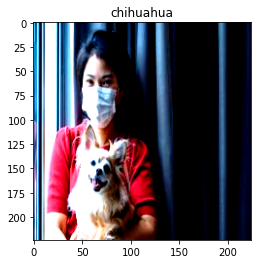

In [151]:
plot(img)